In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.regularizers import l2

In [2]:
# Load the dataset
train_df = pd.read_csv(r"C:\Users\haris\drt\dataset\drugsComTrain_raw.csv", sep=',')
test_df = pd.read_csv(r"C:\Users\haris\drt\dataset\drugsComTest_raw.csv", sep=',')

In [3]:
train_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
# Drop rows with missing values in 'review' or 'rating'
train_test_df = pd.concat([train_df, test_df], ignore_index=True)
train_test_df.dropna(subset=['review', 'rating', 'usefulCount'], inplace=True)
train_test_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [6]:
#remove special charecters from reviews
train_test_df['review'] = train_test_df['review'].str.replace(r'[^\w\s]', '', regex=True)

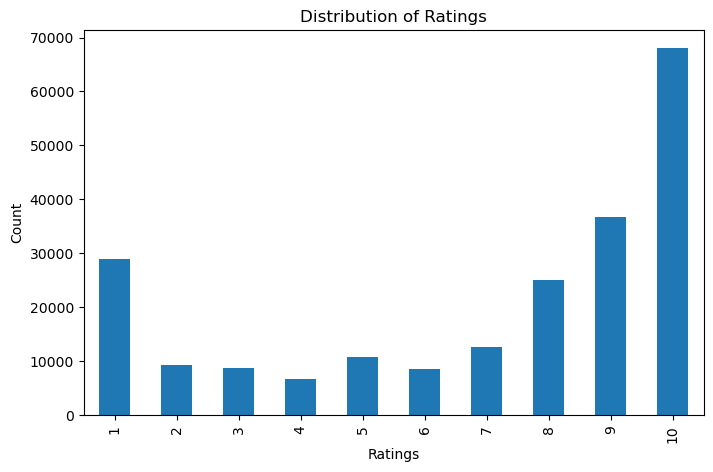

In [86]:
plt.figure(figsize=(8, 5))
train_test_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


In [7]:
train_test=train_test_df

In [8]:
# Convert reviews to lowercase
train_test['review'] = train_test['review'].astype(str).str.lower()

In [9]:
# Generate sentiment labels: 1 for positive, 0 for negative
train_test['sentiment'] = train_test['rating'].apply(lambda x: 1 if x >= 5 else 0)


In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_test['review'], 
    train_test['sentiment'], 
    test_size=0.2, 
    random_state=42
)

In [11]:
# Initialize and fit the vectorizer (term frequency inverse document frequency) tfidf score
vectorizer = TfidfVectorizer(max_features=10000) 
X_train_tfidf = vectorizer.fit_transform(X_train) #sparse matrix with row training review and column with word and tfidf score
X_val_tfidf = vectorizer.transform(X_val)#transform validation data into same feature (if review in 2nd column in  matrix, tfidfscore of drug will also at same column

In [12]:
# Initialize and train the SVM model
svc = LinearSVC(dual=False)
svc.fit(X_train_tfidf, y_train)

LinearSVC(dual=False)

In [13]:
# Validation predictions and metrics
val_pred = svc.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Classification Report:\n", classification_report(y_val, val_pred))

Validation Accuracy: 0.8642038453490805
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.66      0.71     10722
           1       0.89      0.93      0.91     32291

    accuracy                           0.86     43013
   macro avg       0.83      0.80      0.81     43013
weighted avg       0.86      0.86      0.86     43013



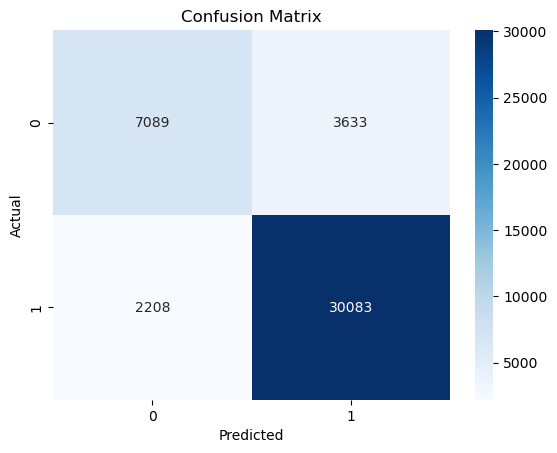

In [14]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_val, val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Generate sentiment labels logistic regression
train_test_lr = train_test_df

In [16]:
# Generate sentiment labels
train_test_lr['sentiment'] = train_test_lr['rating'].apply(lambda x: 0 if x < 5 else (1 if x in [5, 6] else 2))

In [17]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(train_test_lr['review'], train_test_lr['sentiment'], test_size=0.2, random_state=42)

In [18]:
# Text preprocessing with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)


In [19]:
# Train the Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [20]:
# Evaluate the model
y_pred = log_reg.predict(X_val_tfidf)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.7895752446934647
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70     10722
           1       0.40      0.05      0.09      3945
           2       0.82      0.93      0.87     28346

    accuracy                           0.79     43013
   macro avg       0.64      0.56      0.55     43013
weighted avg       0.76      0.79      0.76     43013



In [21]:
train_test_cnn = train_test_df

In [22]:
# Tokenizer and sequence preprocessing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_test_cnn['review'])
train_sequences = tokenizer.texts_to_sequences(train_test_cnn['review'])
max_len = 100
train_data = pad_sequences(train_sequences, maxlen=max_len)

In [23]:
# Convert rating labels to indices (negative, neutral, positive)
train_labels = np.zeros((len(train_test_cnn), 3))
train_labels[:, 0] = train_test_cnn['rating'] < 5
train_labels[:, 1] = (train_test_cnn['rating'] == 5) | (train_test_cnn['rating'] == 6)
train_labels[:, 2] = train_test_cnn['rating'] > 6

train_labels = np.argmax(train_labels, axis=1) #Convert One-Hot Encoding to Class Indices to simplify model training


In [24]:
# CNN model creation
embedding_dim = 50
model = Sequential()
model.add(Embedding(10000, embedding_dim)) # capture semantic relations between words 
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))) #1D conventional operation 64 feature maps trigrams-- model learn complex 
model.add(GlobalMaxPooling1D()) # single value for single filter
model.add(Dense(5, activation='relu', kernel_regularizer=l2(0.01))) #1st dense layer--10 neurons to learn high level features from conv1D 
model.add(Dense(3, activation='softmax')) #output dense layer ( 3 neurons for 3 sentiment classes) softmax ensures 

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
# Train the model
history = model.fit(train_data, train_labels, epochs=30, batch_size=128, validation_split=0.2)


Epoch 1/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6838 - loss: 0.8977 - val_accuracy: 0.7629 - val_loss: 0.6614
Epoch 2/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7825 - loss: 0.6287 - val_accuracy: 0.7949 - val_loss: 0.5933
Epoch 3/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8102 - loss: 0.5631 - val_accuracy: 0.8013 - val_loss: 0.5747
Epoch 4/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8239 - loss: 0.5277 - val_accuracy: 0.8092 - val_loss: 0.5580
Epoch 5/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8339 - loss: 0.5006 - val_accuracy: 0.8099 - val_loss: 0.5554
Epoch 6/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8436 - loss: 0.4790 - val_accuracy: 0.8161 - val_loss: 0.5435
Epoch 7/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8495 - loss: 0.4594 - val_accuracy: 0.8226 - val_loss: 0.5331
Epoch 8/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8575 - loss: 0.4374 -

In [27]:
# Filter the dataset for a specific condition
data_filtered = train_df[train_df['condition'] == "Headache"][['drugName', 'review', 'usefulCount']]


In [28]:
# Extract drug names and reviews
drug_list = data_filtered['drugName'].tolist()
review_list = data_filtered['review'].tolist()
useful_count_list = data_filtered['usefulCount'].tolist()

In [29]:
print(f"Number of reviews : {len(review_list)}")

Number of reviews : 473


In [30]:
# Function for sentiment analysis
def sentiment_analysis_with_useful_count(review):
    review_tfidf = vectorizer.transform([review])
    prediction = svc.predict(review_tfidf)[0]
    return prediction

In [31]:
# Analyze sentiment and aggregate useful counts
drug_sentiment_data = {}

for i, review in enumerate(review_list):
    sentiment = sentiment_analysis_with_useful_count(review)
    drug_name = drug_list[i]
    useful_count = useful_count_list[i]
    
    if drug_name not in drug_sentiment_data:
        drug_sentiment_data[drug_name] = {'positive_count': 0, 'useful_count_sum': 0}
    
    if sentiment == 1:  # Positive sentiment
        drug_sentiment_data[drug_name]['positive_count'] += 1
        drug_sentiment_data[drug_name]['useful_count_sum'] += useful_count
# Convert drug sentiment data to a DataFrame for sorting
drug_summary_df = pd.DataFrame.from_dict(drug_sentiment_data, orient='index')
drug_summary_df['drugName'] = drug_summary_df.index
drug_summary_df.reset_index(drop=True, inplace=True)

# Sort by positive count and useful count sum
drug_summary_df.sort_values(by=['positive_count', 'useful_count_sum'], ascending=False, inplace=True)

In [32]:
# Display the top recommended drugs for svm
top_drugs_SVM = drug_summary_df.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:")
top_drugs_SVM

Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:


,positive_count,useful_count_sum,drugName
0,121,2968,Acetaminophen / butalbital / caffeine
4,81,2791,Fioricet
2,45,376,Acetaminophen / dichloralphenazone / isomethep...
11,19,388,Aspirin / butalbital / caffeine / codeine
3,18,470,Naproxen


In [33]:
# Predict sentiment for the filtered data
reviews = data_filtered['review'].tolist()
drugs = data_filtered['drugName'].tolist()
useful_counts = data_filtered['usefulCount'].tolist()

# Transform reviews to TF-IDF format
reviews_tfidf = tfidf_vectorizer.transform(reviews)

# Predict sentiment
predictions = log_reg.predict(reviews_tfidf)


In [34]:

# Aggregate positive reviews and useful counts
drug_sentiment_data = {}

for i, drug in enumerate(drugs):
    sentiment = predictions[i]
    useful_count = useful_counts[i]

    if drug not in drug_sentiment_data:
        drug_sentiment_data[drug] = {'positive_count': 0, 'useful_count_sum': 0}

    if sentiment == 2:  # Positive sentiment
        drug_sentiment_data[drug]['positive_count'] += 1
        drug_sentiment_data[drug]['useful_count_sum'] += useful_count



In [35]:
# Create a DataFrame for ranking
drug_summary_lr = pd.DataFrame.from_dict(drug_sentiment_data, orient='index')
drug_summary_lr['drugName'] = drug_summary_lr.index
drug_summary_lr.reset_index(drop=True, inplace=True)

# Sort by positive count and useful count sum
drug_summary_lr.sort_values(by=['positive_count', 'useful_count_sum'], ascending=False, inplace=True)

In [36]:
# Display top recommended drugs
top_drugs_lr = drug_summary_lr.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:")
top_drugs_lr

Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:


,positive_count,useful_count_sum,drugName
0,121,2977,Acetaminophen / butalbital / caffeine
4,83,2796,Fioricet
2,42,356,Acetaminophen / dichloralphenazone / isomethep...
3,19,490,Naproxen
11,19,388,Aspirin / butalbital / caffeine / codeine


In [37]:
# Function for sentiment analysis
def sentiment_analysis_direct(review):
    sequence = pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=100)
    prediction = model.predict(sequence)[0]
    sentiment = np.argmax(prediction)
    if sentiment == 0:
        return "Negative"
    elif sentiment == 1:
        return "Neutral"
    elif sentiment == 2:
        return "Positive"


In [38]:
# Extract drug names, reviews, and useful counts
drug_list = data_filtered['drugName'].tolist()
review_list = data_filtered['review'].tolist()
useful_count_list = data_filtered['usefulCount'].tolist()


In [39]:
# Analyze sentiment and aggregate useful counts
drug_sentiment_data = {}

for i, review in enumerate(review_list):
    sentiment = sentiment_analysis_direct(review)
    drug_name = drug_list[i]
    useful_count = useful_count_list[i]
    
    if drug_name not in drug_sentiment_data:
        drug_sentiment_data[drug_name] = {'positive_count': 0, 'useful_count_sum': 0}
    
    if sentiment == "Positive":
        drug_sentiment_data[drug_name]['positive_count'] += 1
        drug_sentiment_data[drug_name]['useful_count_sum'] += useful_count

# Convert drug sentiment data to a DataFrame for sorting
drug_summary_cnn = pd.DataFrame.from_dict(drug_sentiment_data, orient='index')
drug_summary_cnn['drugName'] = drug_summary_cnn.index
drug_summary_cnn.reset_index(drop=True, inplace=True)

# Sort drugs by positive count and useful count sum
drug_summary_cnn.sort_values(by=['positive_count', 'useful_count_sum'], ascending=False, inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [40]:
# Display the top recommended drugs for svm
top_drugs_SVM = drug_summary_df.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:")
top_drugs_SVM

Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:


,positive_count,useful_count_sum,drugName
0,121,2968,Acetaminophen / butalbital / caffeine
4,81,2791,Fioricet
2,45,376,Acetaminophen / dichloralphenazone / isomethep...
11,19,388,Aspirin / butalbital / caffeine / codeine
3,18,470,Naproxen


In [41]:
# Display top recommended drugs for logistic regression
top_drugs_lr = drug_summary_lr.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:")
top_drugs_lr

Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:


,positive_count,useful_count_sum,drugName
0,121,2977,Acetaminophen / butalbital / caffeine
4,83,2796,Fioricet
2,42,356,Acetaminophen / dichloralphenazone / isomethep...
3,19,490,Naproxen
11,19,388,Aspirin / butalbital / caffeine / codeine


In [42]:
# Display the top recommended drugs for cnn
top_drugs_cnn = drug_summary_cnn.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for cnn:")
top_drugs_cnn

Top Recommended Drugs Based on Positive Reviews and Useful Count for cnn:


,positive_count,useful_count_sum,drugName
0,91,2307,Acetaminophen / butalbital / caffeine
4,63,2180,Fioricet
2,31,277,Acetaminophen / dichloralphenazone / isomethep...
11,18,354,Aspirin / butalbital / caffeine / codeine
3,13,377,Naproxen
